# Forcing ratios calculated using Gregory regression

In [111]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from estimation import *

In [112]:
models_2x = ['CESM2',
 'CNRM-CM6-1',
 'CanESM5',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'GISS-E2-2-G',
 'GISS-E2-2-H',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0',
 'TaiESM1',
 'HadGEM3-GC31-LL']

models_0p5x = ['CESM2',
 'CNRM-CM6-1',
 'CanESM5',
 'GISS-E2-1-G',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0',
 'TaiESM1',
 'HadGEM3-GC31-LL']

# Studying 12 models with abrupt-2xCO2

In [113]:
reglengths = [5, 10, 20, 30]
forcing_ratio_df = pd.DataFrame([],index = models_2x + ['Ensemble mean','Mean of model results'], columns = reglengths + ['Mean'])



mean forcing ratio when regressing 5 years is: 0.5028746349373839
mean forcing ratio when regressing 10 years is: 0.4980858793488252
mean forcing ratio when regressing 20 years is: 0.4931709322855175
mean forcing ratio when regressing 30 years is: 0.5041034305122435


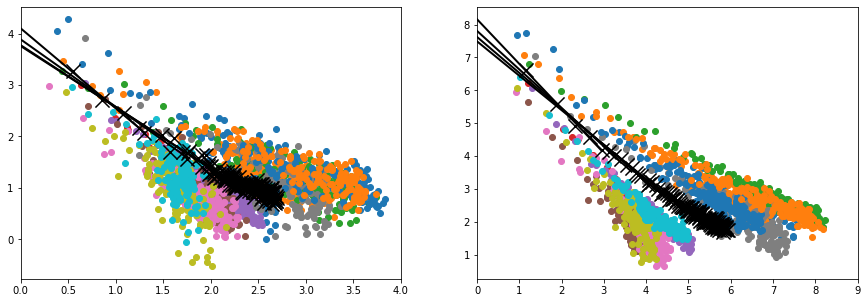

In [114]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))

for (mm, model) in enumerate(models_2x):
    
    members_2x = find_members(model, exp = 'abrupt-2xCO2')
    membermean_T_2x = member_mean_tas(model, members_2x, length_restriction = 150, exp = 'abrupt-2xCO2')[1:]
    membermean_N_2x = mean_4xCO2toarad(model, members_2x, length_restriction = 150, exp = 'abrupt-2xCO2') #works also for other exp than 4xCO2
    model_df_T_2x = pd.DataFrame(membermean_T_2x, columns = [model])
    model_df_N_2x = pd.DataFrame(membermean_N_2x, columns = [model])
    ax[0].scatter(membermean_T_2x, membermean_N_2x)
    
    members_4x = find_members(model, exp = 'abrupt-4xCO2')
    if model == 'GISS-E2-1-G':
        # exclude member which seems to start after year 150
        members_4x.remove('r1i1p1f3')
    membermean_T_4x = member_mean_tas(model, members_4x, length_restriction = 150, exp = 'abrupt-4xCO2')[1:]
    membermean_N_4x = mean_4xCO2toarad(model, members_4x, length_restriction = 150, exp = 'abrupt-4xCO2')
    model_df_T_4x = pd.DataFrame(membermean_T_4x, columns = [model])
    model_df_N_4x = pd.DataFrame(membermean_N_4x, columns = [model])
    ax[1].scatter(membermean_T_4x, membermean_N_4x)
    
    for regyears in reglengths:
        model_reg_2x = np.polyfit(membermean_T_2x[:regyears], membermean_N_2x[:regyears], deg = 1)
        model_reg_4x = np.polyfit(membermean_T_4x[:regyears], membermean_N_4x[:regyears], deg = 1)
        forcing_ratio = model_reg_2x[1]/model_reg_4x[1]
        #forcing_ratio = model_reg_4x[1]/model_reg_2x[1]
        
        forcing_ratio_df[regyears].loc[model] = forcing_ratio
        #if regyears == 5:
        #    forcing_ratio_list.append(forcing_ratio)
        #print(model, 'forcing ratio when regressing', regyears, 'years is:', forcing_ratio)
    forcing_ratio_df.loc[model]['Mean'] = np.nanmean(forcing_ratio_df.loc[model].values)
    
    if mm == 0: # first model
        df_T_2x = model_df_T_2x
        df_N_2x = model_df_N_2x
        df_T_4x = model_df_T_4x
        df_N_4x = model_df_N_4x
    else:
        df_T_2x = pd.concat([df_T_2x, model_df_T_2x], axis = 1, ignore_index = True)
        df_N_2x = pd.concat([df_N_2x, model_df_N_2x], axis = 1, ignore_index = True)
        df_T_4x = pd.concat([df_T_4x, model_df_T_4x], axis = 1, ignore_index = True)
        df_N_4x = pd.concat([df_N_4x, model_df_N_4x], axis = 1, ignore_index = True)
        
model_mean_T_2x = df_T_2x.mean(axis=1)
model_mean_N_2x = df_N_2x.mean(axis=1)
ax[0].scatter(model_mean_T_2x, model_mean_N_2x, marker = 'x', color = 'black', s = 200)
model_mean_T_4x = df_T_4x.mean(axis=1)
model_mean_N_4x = df_N_4x.mean(axis=1)
ax[1].scatter(model_mean_T_4x, model_mean_N_4x, marker = 'x', color = 'black', s = 200)



print('\n')
for regyears in [5, 10, 20, 30]:

    reg_2x = np.polyfit(model_mean_T_2x[:regyears], model_mean_N_2x[:regyears], deg = 1)
    T_incl0 = np.concatenate([[0], model_mean_T_2x[:regyears].values])
    linfit_2x = np.polyval(reg_2x, T_incl0)
    ax[0].plot(T_incl0, linfit_2x, color = 'black', linewidth = 2)

    reg_4x = np.polyfit(model_mean_T_4x[:regyears], model_mean_N_4x[:regyears], deg = 1)
    T_incl0 = np.concatenate([[0], model_mean_T_4x[:regyears].values])
    linfit_4x = np.polyval(reg_4x, T_incl0)
    ax[1].plot(T_incl0, linfit_4x, color = 'black', linewidth = 2)

    print('mean forcing ratio when regressing', regyears, 'years is:', reg_2x[1]/reg_4x[1])
    #print('mean forcing ratio when regressing', regyears, 'years is:', reg_4x[1]/reg_2x[1])
    forcing_ratio_df.loc['Ensemble mean'][regyears] = reg_2x[1]/reg_4x[1]
forcing_ratio_df.loc['Ensemble mean']['Mean'] = np.nanmean(forcing_ratio_df.loc['Ensemble mean'].values)

ax[0].set_xlim(0,4)
ax[1].set_xlim(0,9)

for col in forcing_ratio_df.columns:
    forcing_ratio_df.loc['Mean of model results'][col] = forcing_ratio_df.loc[models_2x][col].mean()

In [115]:
forcing_ratio_df

,5,10,20,30,Mean
CESM2,0.497924,0.543408,0.540948,0.545237,0.531879
CNRM-CM6-1,0.511743,0.496612,0.502293,0.543517,0.513541
CanESM5,0.480258,0.484929,0.487447,0.492388,0.486256
GISS-E2-1-G,0.494793,0.489364,0.482534,0.485679,0.488093
GISS-E2-1-H,0.488067,0.514708,0.494374,0.517138,0.503572
GISS-E2-2-G,0.530218,0.529147,0.555158,0.56582,0.545086
GISS-E2-2-H,0.480794,0.505827,0.490792,0.451877,0.482322
IPSL-CM6A-LR,0.638259,0.538598,0.516027,0.528128,0.555253
MIROC6,0.532366,0.440486,0.423334,0.446311,0.460624
MRI-ESM2-0,0.495043,0.485585,0.459035,0.470622,0.477571


In [110]:
#forcing_ratio_df.to_csv('../Other_estimates/forcing_ratios_2x_to_4x.csv')

<AxesSubplot:>

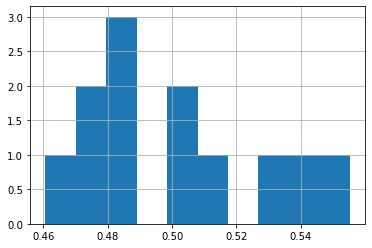

In [73]:
forcing_ratio_df['Mean'].hist()

In [74]:
forcing_ratio_df['Mean'].mean()

0.5016506089574139

In [116]:
s = forcing_ratio_df.style.format(precision=2)
s.set_table_styles([
        {'selector': 'toprule', 'props': ':hline;'},
        {'selector': 'midrule', 'props': ':hline;'},
        {'selector': 'bottomrule', 'props': ':hline;'}])
print(s.to_latex(column_format= 'lccccc'))

\begin{tabular}{lccccc}
\hline
 & 5 & 10 & 20 & 30 & Mean \\
\hline
CESM2 & 0.50 & 0.54 & 0.54 & 0.55 & 0.53 \\
CNRM-CM6-1 & 0.51 & 0.50 & 0.50 & 0.54 & 0.51 \\
CanESM5 & 0.48 & 0.48 & 0.49 & 0.49 & 0.49 \\
GISS-E2-1-G & 0.49 & 0.49 & 0.48 & 0.49 & 0.49 \\
GISS-E2-1-H & 0.49 & 0.51 & 0.49 & 0.52 & 0.50 \\
GISS-E2-2-G & 0.53 & 0.53 & 0.56 & 0.57 & 0.55 \\
GISS-E2-2-H & 0.48 & 0.51 & 0.49 & 0.45 & 0.48 \\
IPSL-CM6A-LR & 0.64 & 0.54 & 0.52 & 0.53 & 0.56 \\
MIROC6 & 0.53 & 0.44 & 0.42 & 0.45 & 0.46 \\
MRI-ESM2-0 & 0.50 & 0.49 & 0.46 & 0.47 & 0.48 \\
TaiESM1 & 0.50 & 0.49 & 0.51 & 0.52 & 0.51 \\
HadGEM3-GC31-LL & 0.43 & 0.48 & 0.48 & 0.49 & 0.47 \\
Ensemble mean & 0.50 & 0.50 & 0.49 & 0.50 & 0.50 \\
Mean of model results & 0.51 & 0.50 & 0.50 & 0.51 & 0.50 \\
\hline
\end{tabular}



## Forcing ratio between 0p5xCO2 and 2xCO2



mean forcing ratio when regressing 5 years is: -1.1573301174816406
mean forcing ratio when regressing 10 years is: -1.1465040270852493
mean forcing ratio when regressing 20 years is: -1.124280061852229
mean forcing ratio when regressing 30 years is: -1.1526690878189154


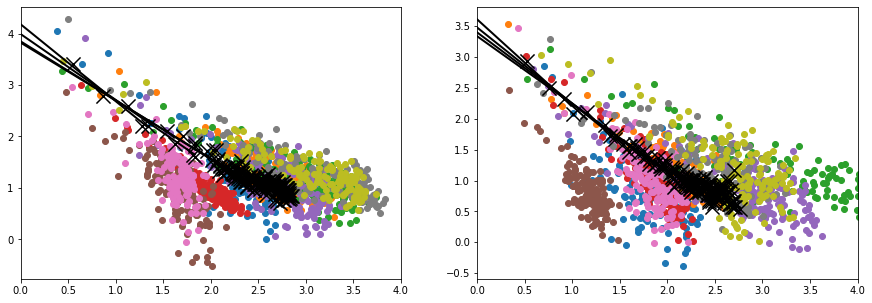

In [117]:
forcing_ratio_df2 = pd.DataFrame([],index = models_0p5x + ['Ensemble mean','Mean of model results'], columns = reglengths + ['Mean'])

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))

for (mm, model) in enumerate(models_0p5x):
    
    members_2x = find_members(model, exp = 'abrupt-2xCO2')
    membermean_T_2x = member_mean_tas(model, members_2x, length_restriction = 150, exp = 'abrupt-2xCO2')[1:]
    membermean_N_2x = mean_4xCO2toarad(model, members_2x, length_restriction = 150, exp = 'abrupt-2xCO2') #works also for other exp than 4xCO2
    model_df_T_2x = pd.DataFrame(membermean_T_2x, columns = [model])
    model_df_N_2x = pd.DataFrame(membermean_N_2x, columns = [model])
    ax[0].scatter(membermean_T_2x, membermean_N_2x)
    
    members_0p5 = find_members(model, exp = 'abrupt-0p5xCO2')
    membermean_T_0p5 = member_mean_tas(model, members_0p5, length_restriction = 150, exp = 'abrupt-0p5xCO2')[1:]
    membermean_N_0p5 = mean_4xCO2toarad(model, members_0p5, length_restriction = 150, exp = 'abrupt-0p5xCO2') #works also for other exp than 4xCO2
    model_df_T_0p5 = pd.DataFrame(membermean_T_0p5, columns = [model])
    model_df_N_0p5 = pd.DataFrame(membermean_N_0p5, columns = [model])
    ax[1].scatter(-membermean_T_0p5, -membermean_N_0p5)
    
    for regyears in reglengths:
        model_reg_2x = np.polyfit(membermean_T_2x[:regyears], membermean_N_2x[:regyears], deg = 1)
        model_reg_0p5 = np.polyfit(membermean_T_0p5[:regyears], membermean_N_0p5[:regyears], deg = 1)
        forcing_ratio = model_reg_2x[1]/model_reg_0p5[1]
        forcing_ratio_df2[regyears].loc[model] = forcing_ratio
        #if regyears == 5:
        #    forcing_ratio_list.append(forcing_ratio)
        #print(model, 'forcing ratio when regressing', regyears, 'years is:', forcing_ratio)
    forcing_ratio_df2.loc[model]['Mean'] = np.nanmean(forcing_ratio_df2.loc[model].values)
    
    if mm == 0: # first model
        df_T_2x = model_df_T_2x
        df_N_2x = model_df_N_2x
        df_T_0p5 = model_df_T_0p5
        df_N_0p5 = model_df_N_0p5
    else:
        df_T_2x = pd.concat([df_T_2x, model_df_T_2x], axis = 1, ignore_index = True)
        df_N_2x = pd.concat([df_N_2x, model_df_N_2x], axis = 1, ignore_index = True)
        df_T_0p5 = pd.concat([df_T_0p5, model_df_T_0p5], axis = 1, ignore_index = True)
        df_N_0p5 = pd.concat([df_N_0p5, model_df_N_0p5], axis = 1, ignore_index = True)
        
model_mean_T_2x = df_T_2x.mean(axis=1)
model_mean_N_2x = df_N_2x.mean(axis=1)
ax[0].scatter(model_mean_T_2x, model_mean_N_2x, marker = 'x', color = 'black', s = 200)
model_mean_T_0p5 = df_T_0p5.mean(axis=1)
model_mean_N_0p5 = df_N_0p5.mean(axis=1)
ax[1].scatter(-model_mean_T_0p5, -model_mean_N_0p5, marker = 'x', color = 'black', s = 200)

    
print('\n')
for regyears in [5, 10, 20, 30]:

    reg_2x = np.polyfit(model_mean_T_2x[:regyears], model_mean_N_2x[:regyears], deg = 1)
    T_incl0 = np.concatenate([[0], model_mean_T_2x[:regyears].values])
    linfit_2x = np.polyval(reg_2x, T_incl0)
    ax[0].plot(T_incl0, linfit_2x, color = 'black', linewidth = 2)

    reg_0p5 = np.polyfit(model_mean_T_0p5[:regyears], model_mean_N_0p5[:regyears], deg = 1)
    T_incl0 = np.concatenate([[0], model_mean_T_0p5[:regyears].values])
    linfit_0p5 = np.polyval(reg_0p5, T_incl0)
    ax[1].plot(-T_incl0, -linfit_0p5, color = 'black', linewidth = 2)

    print('mean forcing ratio when regressing', regyears, 'years is:', reg_2x[1]/reg_0p5[1])
    forcing_ratio_df2.loc['Ensemble mean'][regyears] = reg_2x[1]/reg_0p5[1]
forcing_ratio_df2.loc['Ensemble mean']['Mean'] = np.nanmean(forcing_ratio_df2.loc['Ensemble mean'].values)

ax[0].set_xlim(0,4)
ax[1].set_xlim(0,4)

for col in forcing_ratio_df.columns:
    forcing_ratio_df2.loc['Mean of model results'][col] = forcing_ratio_df2.loc[models_0p5x][col].mean()

In [118]:
forcing_ratio_df2

,5,10,20,30,Mean
CESM2,-0.751366,-1.10799,-1.175647,-1.283329,-1.079583
CNRM-CM6-1,-1.109376,-1.158668,-1.133744,-1.217004,-1.154698
CanESM5,-1.055649,-1.155023,-1.114156,-1.080194,-1.101256
GISS-E2-1-G,-1.030832,-0.994139,-0.999861,-1.017732,-1.010641
IPSL-CM6A-LR,-1.534645,-1.320118,-1.401584,-1.365429,-1.405444
MIROC6,-1.331307,-1.137342,-1.067222,-1.141598,-1.169367
MRI-ESM2-0,-0.937331,-0.95187,-0.86825,-0.861271,-0.90468
TaiESM1,-1.257452,-1.28292,-1.335919,-1.359366,-1.308914
HadGEM3-GC31-LL,-1.04996,-1.016387,-0.977939,-0.989063,-1.008337
Ensemble mean,-1.15733,-1.146504,-1.12428,-1.152669,-1.145196


In [109]:
#forcing_ratio_df2.to_csv('../Other_estimates/forcing_ratios_2x_to_0p5x.csv')

In [119]:
s2 = forcing_ratio_df2.style.format(precision=2)
s2.set_table_styles([
        {'selector': 'toprule', 'props': ':hline;'},
        {'selector': 'midrule', 'props': ':hline;'},
        {'selector': 'bottomrule', 'props': ':hline;'}])
print(s2.to_latex(column_format= 'lccccc'))

\begin{tabular}{lccccc}
\hline
 & 5 & 10 & 20 & 30 & Mean \\
\hline
CESM2 & -0.75 & -1.11 & -1.18 & -1.28 & -1.08 \\
CNRM-CM6-1 & -1.11 & -1.16 & -1.13 & -1.22 & -1.15 \\
CanESM5 & -1.06 & -1.16 & -1.11 & -1.08 & -1.10 \\
GISS-E2-1-G & -1.03 & -0.99 & -1.00 & -1.02 & -1.01 \\
IPSL-CM6A-LR & -1.53 & -1.32 & -1.40 & -1.37 & -1.41 \\
MIROC6 & -1.33 & -1.14 & -1.07 & -1.14 & -1.17 \\
MRI-ESM2-0 & -0.94 & -0.95 & -0.87 & -0.86 & -0.90 \\
TaiESM1 & -1.26 & -1.28 & -1.34 & -1.36 & -1.31 \\
HadGEM3-GC31-LL & -1.05 & -1.02 & -0.98 & -0.99 & -1.01 \\
Ensemble mean & -1.16 & -1.15 & -1.12 & -1.15 & -1.15 \\
Mean of model results & -1.12 & -1.12 & -1.12 & -1.15 & -1.13 \\
\hline
\end{tabular}

